<a href="https://colab.research.google.com/github/joannedonohue/Project-2-Group-3/blob/main/FInal_Walmart_Sales_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Overview

### 45 stores including store information and weekly sales.
### Walmart tries to find the impact of holidays on the sales of store.
### four holidays’ weeks into the dataset which are Christmas, Thanksgiving, Super bowl, Labor Day


## Questions:
### Can we analyze the stores to see top/worst performing?
### Can we predict sales overall? - Aggregate store level sales then predict next 8 weeks of sales, using Prophet
### Is there a spike in sales during holidays using Holiday Flag?
### Is there a relationship between sales and variables like Temp, Fuel Price, CPI and Unemployment
    # Can we do this at a store level or aggregated?
### Can we predict store level sales?
### Can we combine from other data sets or fake data?
### Can we classify stores into groups of "like" stores?
    # ex. more price sensitive vs. less price sensitive using local fuel and unemployment data (is it regional?)
### can we visualize this data in a unique way?



# Load Libraries & Dataset

In [ ]:
from google.colab import files

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.colors import PowerNorm

import seaborn as sns


import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
# Load Walmart Sales data
# Source: https://www.kaggle.com/datasets/yasserh/walmart-dataset?resource=download

# For use in Jupyter Notebook
# sales_data = pd.read_csv("Resources/Walmart.csv")
# sales_data.head()
# sales_data

# For use in Google Collab
uploaded = files.upload()


Saving Walmart.csv to Walmart (1).csv


In [ ]:
# This step only needed in Google Collab, otherwise comment out and skip
df = pd.read_csv(
    "Walmart.csv",
    # index_col='Store',
    parse_dates=True,
    infer_datetime_format=True
).dropna()

<ipython-input-32-1f1ba7ae983b>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


# Clean and Explore Data

In [ ]:
# Explore the dataset

# Change date to datetime data type
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Add Day Month Year columns
df['Day'] = df.Date.dt.day
df['Month'] = df.Date.dt.month
df['Year'] = df.Date.dt.year

print(f"""

{df.info()}

Number of Stores: {len(df['Store'].unique())}

Min Date:
{min(df['Date'])}

Max Date:
{max(df['Date'])}

Missing Values:
{df.isnull().sum()}

Duplicate values:
{df.duplicated().sum()}

First few Rows:
{df.head()}

Summary Statistics:
{df.describe().round(2)}
""")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
 8   Day           6435 non-null   int32         
 9   Month         6435 non-null   int32         
 10  Year          6435 non-null   int32         
dtypes: datetime64[ns](1), float64(5), int32(3), int64(2)
memory usage: 477.7 KB


None

Number of Stores: 45

Min Date: 
2010-02-05 00:00:00
      
Max Date: 
2012-10-26 00:00:00

Missing Values:
Store           0
Date            0
Weekly_Sal

# Visualize Data for additional exploration

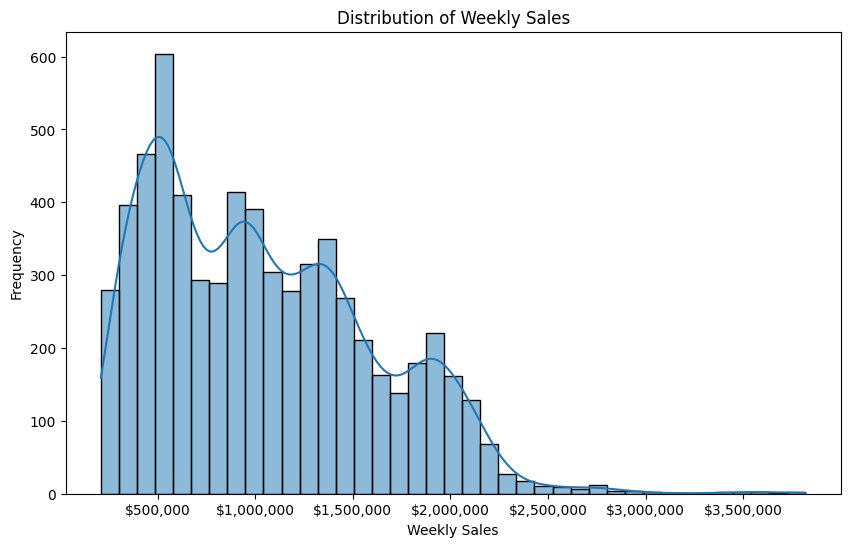

In [ ]:
# Graph 1 Distribution

# Plot the distribution of Weekly Sales
plt.figure(figsize=(10, 6))
sns.histplot(df['Weekly_Sales'], kde=True)

# Formatting x axis to show dollars
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Adding Titles and Labels
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')

# Show plot
plt.show()


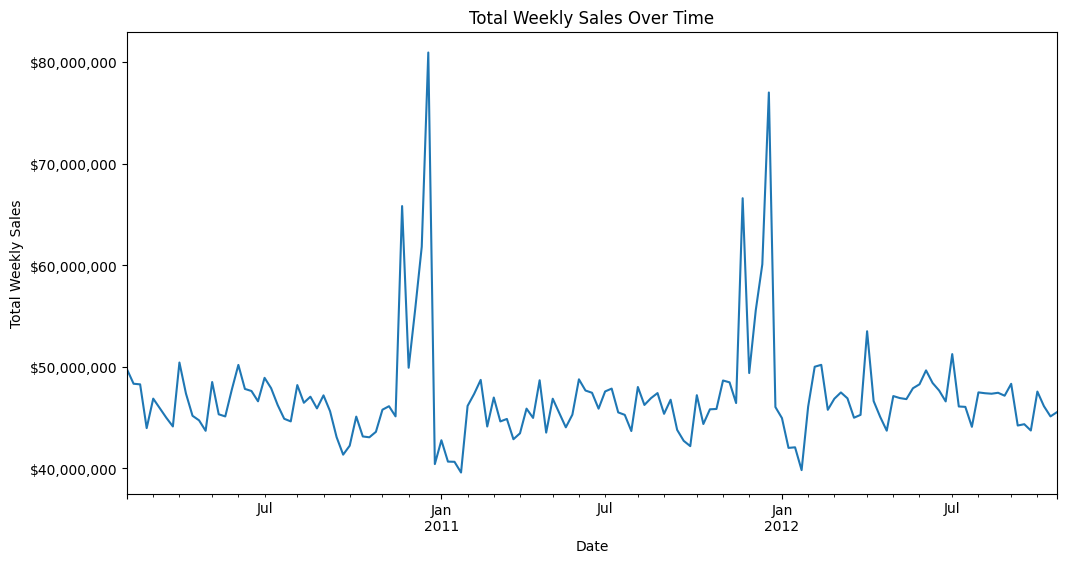

In [ ]:
#Graph 2 Trend

# Plot sales trend over time
plt.figure(figsize=(12, 6))
df.groupby('Date')['Weekly_Sales'].sum().plot()

# Formatting y axis to show dollars
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Adding Titles and Labels
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')

# Show plot
plt.show()

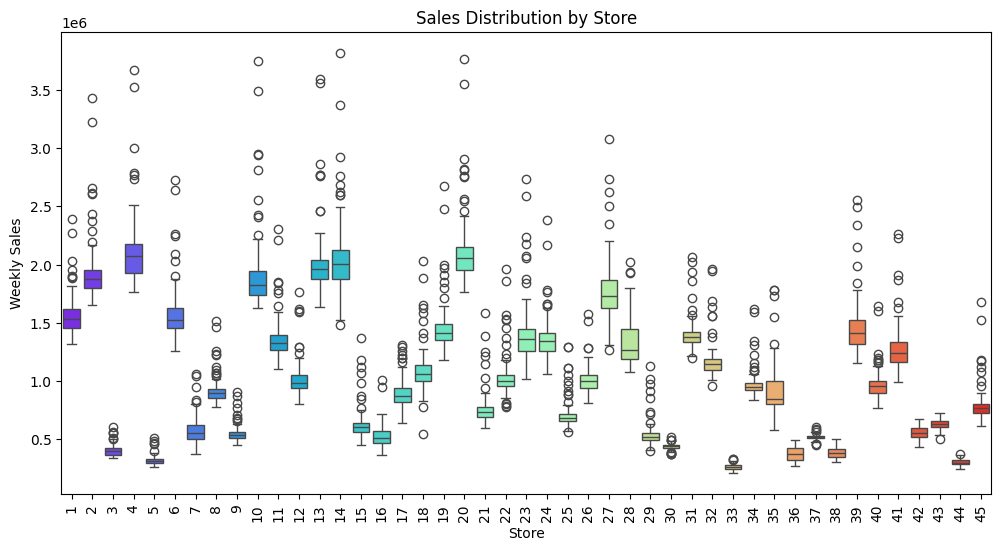

In [ ]:
# Sales Distribution by Store

# Create a unique color for each store using the 'rainbow' palette
num_stores = df['Store'].nunique()
palette = sns.color_palette("rainbow", num_stores)

# Create a boxplot with hue assigned to the 'Store' variable
plt.figure(figsize=(12, 6))
sns.boxplot(x='Store', y='Weekly_Sales', data=df, hue='Store', palette=palette, dodge=False, legend=False)

# Add labels and title
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.title('Sales Distribution by Store')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()

# Explore correlation between features




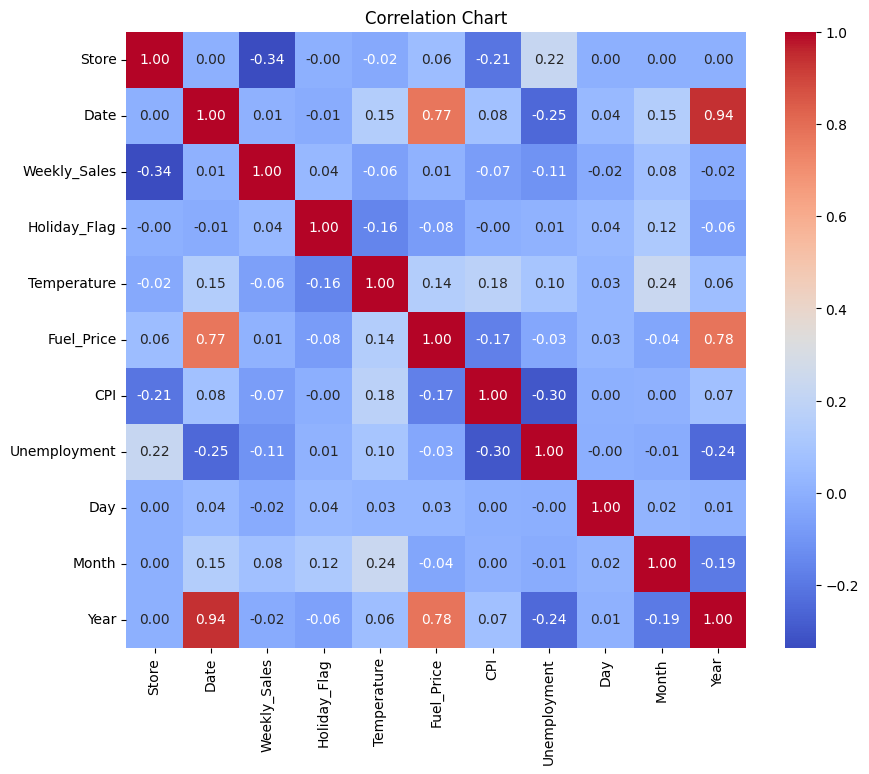

In [ ]:
corr_matrix = df.corr()

# Heatmap colors: https://seaborn.pydata.org/tutorial/color_palettes.html

plt.figure(figsize=(10, 8))  # Adjust the figure size if needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')  # fmt='.2f' limits decimal places
plt.title('Correlation Chart')
plt.show()


# Observations:

- Strongest useable correlation is between Store # and Weekly Sales at 34%, which indicates that stores are consistent in their sales performance
- Next best correlation is between Sales and Unemployment at -11%, followed by the CPI at -7%
- Somewhat surprisingly, fuel price and holiday had a neutral correlation with weekly sales. This could be a function of few holiday weeks in the data and store proximity to home, work or public transportation.

## CPI Information:

`CPI_t=\frac{C_t}{C_0} * 100`

CPI_t	=	consumer price index in current period

C_t	=	cost of market basket in current period

C_0	=	cost of market basket in base period


# Explore Store level info for Sales vs. Unemployment Rate and CPI

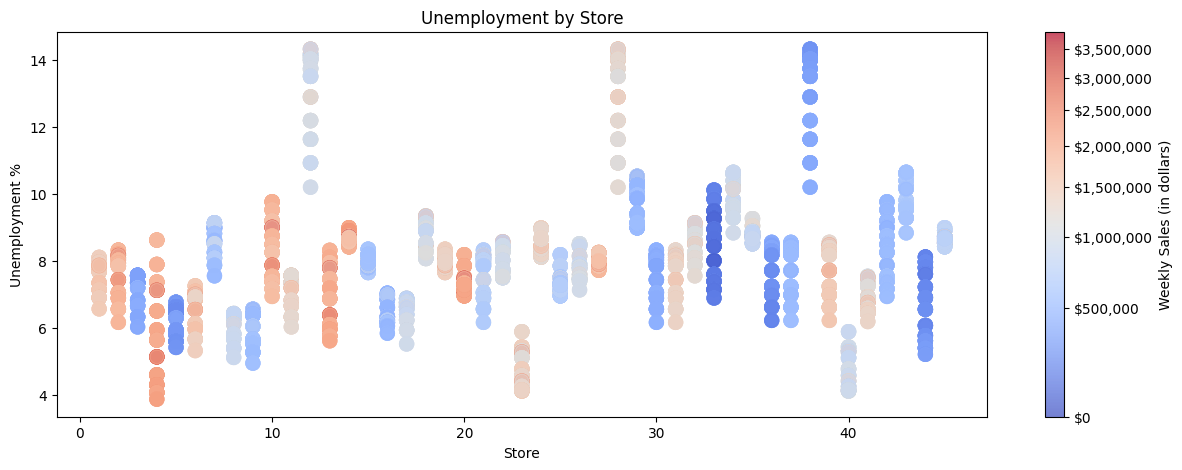

In [ ]:
# Unemployment by Store with Weekly Sales Color emphasis

# Create variables
x = df['Store']
y = df['Unemployment']
sales = df['Weekly_Sales']  # Weekly sales column for color coding

# Apply PowerNorm to emphasize high and low sales values
norm = PowerNorm(gamma=0.5, vmin=sales.min(), vmax=sales.max())  # Lower gamma value emphasizes extremes

# Create scatter plot with color coding based on weekly sales
plt.figure(figsize=(15, 5))
scatter = plt.scatter(x, y, c=sales, cmap='coolwarm', s=100, alpha=0.7, norm=norm)

# Add color bar to indicate sales values
cbar = plt.colorbar(scatter)
cbar.set_label('Weekly Sales (in dollars)')
cbar.ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))  # Format color bar as dollars

# Add labels
plt.title('Unemployment by Store')
plt.xlabel('Store')
plt.ylabel('Unemployment %')

# Show plot
plt.show()

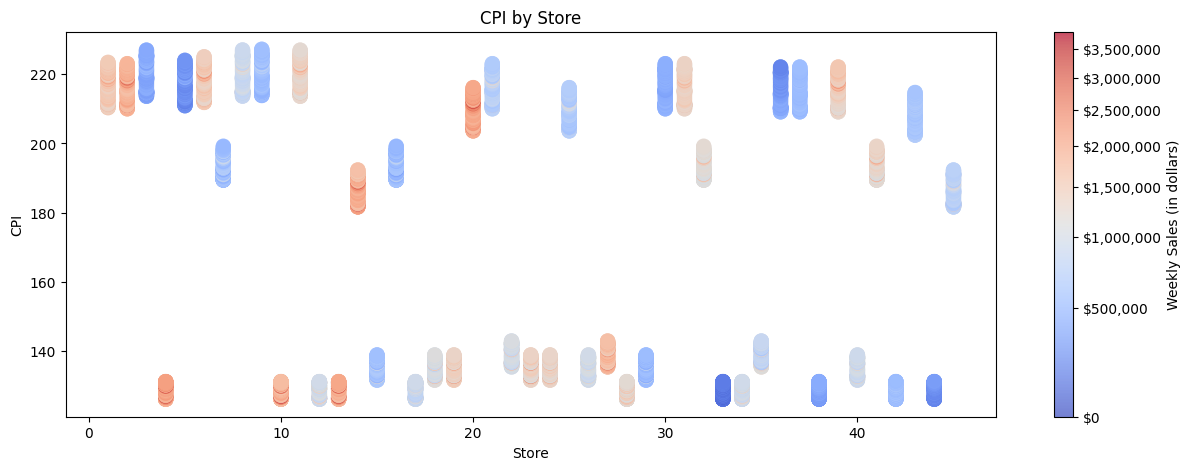

In [ ]:
# # CPI by Store with Weekly Sales Color emphasis

# Create variables
x = df['Store']
y = df['CPI']
sales = df['Weekly_Sales']  # Weekly sales column for color coding

# Apply PowerNorm to emphasize high and low sales values
norm = PowerNorm(gamma=0.5, vmin=sales.min(), vmax=sales.max())  # Lower gamma value emphasizes extremes

# Create scatter plot with color coding based on weekly sales
plt.figure(figsize=(15, 5))
scatter = plt.scatter(x, y, c=sales, cmap='coolwarm', s=100, alpha=0.7, norm=norm)

# Add color bar to indicate sales values
cbar = plt.colorbar(scatter)
cbar.set_label('Weekly Sales (in dollars)')
cbar.ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))  # Format color bar as dollars

# Add labels
plt.title('CPI by Store')
plt.xlabel('Store')
plt.ylabel('CPI')

# Show plot
plt.show()

# KMeans clustering of Stores

In [ ]:
# Select only numeric columns before grouping and calculating mean
numeric_columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
store_data = df.groupby('Store')[numeric_columns].mean()

# Scale the aggregated store-level data
scaler = StandardScaler()
scaled_store_features = scaler.fit_transform(store_data)

# Apply KMeans clustering to the stores
kmeans_store = KMeans(n_clusters=3, random_state=42)
store_data['Cluster'] = kmeans_store.fit_predict(scaled_store_features)
store_data['Weekly_Sales'] = store_data['Weekly_Sales'].apply(lambda x: '${:,.2f}'.format(x))


# Display the store data with the cluster labels
store_data[['Weekly_Sales', 'Cluster']].head()


,Weekly_Sales,Cluster
Store,,
1,"$1,555,264.40",2
2,"$1,925,751.34",2
3,"$402,704.44",2
4,"$2,094,712.96",0
5,"$318,011.81",2


In [ ]:
# Display all stores with their corresponding cluster labels
store_data[['Weekly_Sales', 'Cluster']]


,Weekly_Sales,Cluster
Store,,
1,"$1,555,264.40",2
2,"$1,925,751.34",2
3,"$402,704.44",2
4,"$2,094,712.96",0
5,"$318,011.81",2
6,"$1,564,728.19",2
7,"$570,617.31",0
8,"$908,749.52",2
9,"$543,980.55",2


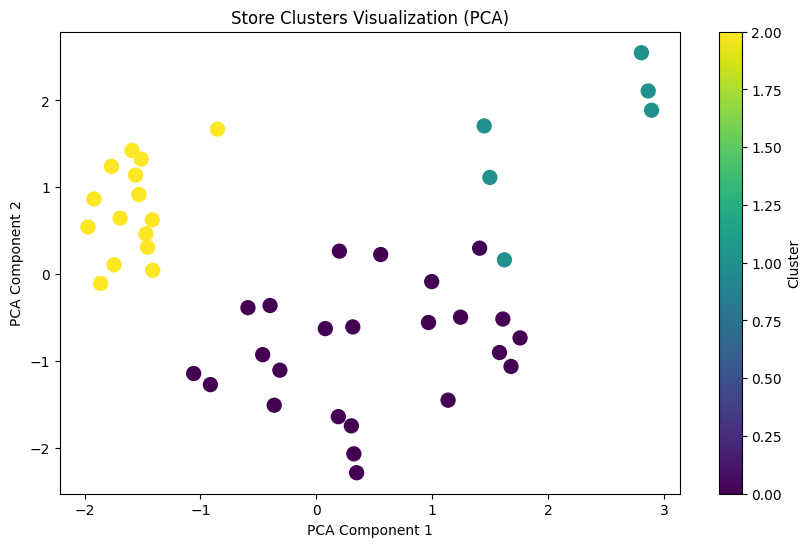

In [ ]:
# Reduce the dimensionality of the data to 2 components for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_store_features)

# Create a scatter plot for the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=store_data['Cluster'], cmap='viridis', s=100)

# Create labels
plt.title('Store Clusters Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')

# Show plot
plt.show()


# Visualing Feature Importance in preparation for Sales Prediction modeling


In [ ]:
features = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day']
X = df[features]
y = df['Weekly_Sales']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 13504777637.656548
R-squared Score: 0.958079819067563


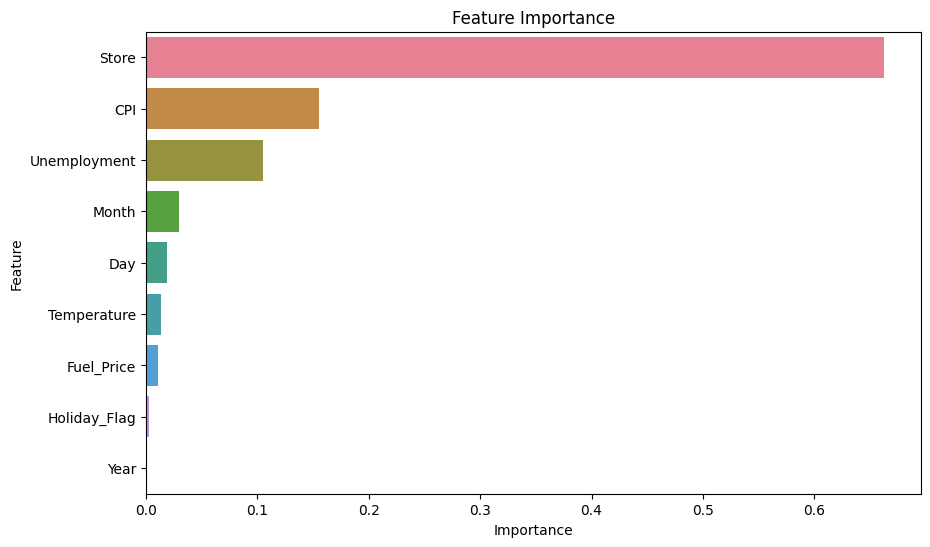

In [ ]:
# Create a DataFrame with feature importances
feature_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Generate a color palette with different colors for each bar
num_features = len(feature_importance)
palette = sns.color_palette("husl", num_features)  # 'husl' generates a range of distinct colors

# Create the barplot with hue assigned to 'feature'
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, hue='feature', palette=palette, dodge=False, legend=False)

# Add labels and title
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Show the plot
plt.show()

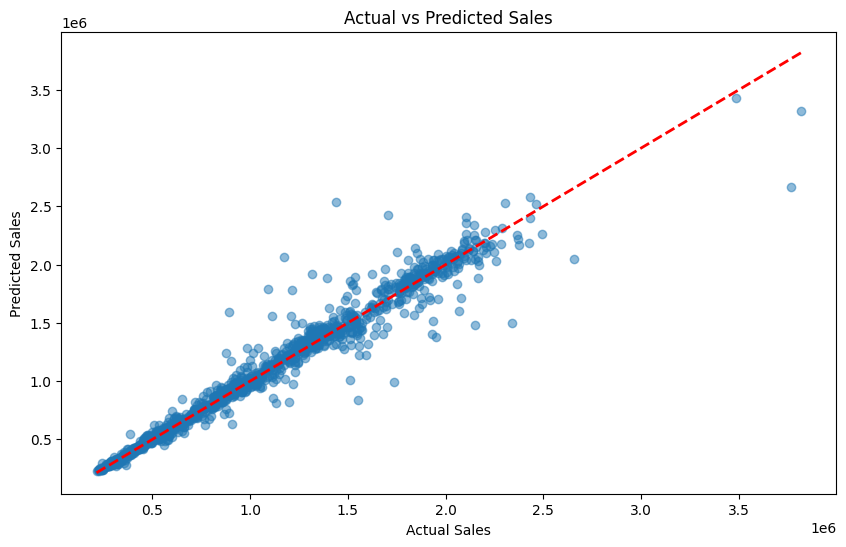

In [ ]:
# Actual vs Predicted Sales

# Create figure
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

# Create labels
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')

# show plot
plt.show()